# Calculate loss score of false triples 

## modules

In [1]:
import torch
import json
import pylab as plt
import pandas as pd
from sources.evaluation import vanilla_hits_at_k
from IPython.display import display, HTML
from pykeen.datasets import get_dataset
from util.databinder import DataBinder
from pykeen.evaluation import RankBasedEvaluator
from sklearn.metrics import precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

/home/acg16558pn/kg_20240423/lib/python3.10/site-packages/pykeen/evaluation/evaluator.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## parameters

In [2]:
# directory for trained model
# ----------------------------------------------------------------
#dir_model = './models/20240606/wn18rr_transe/'
dir_model = './models/20240606/kinships_transe/'
#dir_model = './models/20240628_distmultliteral/model_without_lit'
#dir_model = './models/20240606/fb15k237_transe_no_option'

# name of dataset
# ----------------------------------------------------------------
dataset_name = 'kinships'

# directory for false triples
dir_false_triples = './data/processed/20240725_false_kinships'
#dir_false_triples = './data/processed/20240725_false_fb15k237'
#dir_false_triples = './data/processed/20240725_false_wn18rr'

# direcory for report
# ----------------------------------------------------------------
dir_report = './reports/20240725/kinships_transe_false_triple_analysis'

## main

In [3]:
dataset = get_dataset(dataset=dataset_name, dataset_kwargs={'create_inverse_triples':True})

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///home/acg16558pn/.data/pykeen/datasets/kinships/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/kinships/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/kinships/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/kinships/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


### false triples

In [4]:
db_false_triples = DataBinder(target_dir=dir_false_triples)
list_random_seed = db_false_triples.get('list_random_seed')
dict_false_triples = {}
for random_seed in list_random_seed:
    i = int(random_seed)
    dict_false_triples[i] = {}
    dict_false_triples[i]['tf'] = db_false_triples.get(f'tf_{random_seed}')
    dict_false_triples[i]['tt'] = db_false_triples.get(f'tt_{random_seed}')
    dict_false_triples[i]['df_feature'] = db_false_triples.get(f'df_tt_tf_features_{random_seed}')

INFO:root:Loaded info from ./data/processed/20240725_false_kinships/info.json


### knowledge graph embeddign model

In [5]:
# embedding model
kge_model = torch.load(f'{dir_model}/trained_model.pkl')

In [6]:
## embeddign model information
with open(f'{dir_model}/results.json') as fin:
    dict_model_info = json.load(fin)

### Hits@k of the knowledge graph embedding model (calculated by pykeen)

In [7]:
dict_data = {}
for i in [1,3,5,10]:
    dict_data[i] = dict_model_info['metrics']['both']['realistic'][f'hits_at_{i}']

In [8]:
sr_hits_at_k = pd.Series(dict_data, name='hits@k')
sr_hits_at_k.index.name = 'k'

In [9]:
sr_hits_at_k.to_frame().T

k,1,3,5,10
hits@k,0.068436,0.283985,0.410149,0.587058


### Median rank of knoweldge  graph embeddign model (calculated by pykeen)

In [10]:
mr = dict_model_info['metrics']['both']['realistic']['median_rank']

In [11]:
print(mr)

8.0


### Hits@k of knowledge graph embeddign model (calculated by homemade function)

In [12]:
dict_data = vanilla_hits_at_k(kge_model, dataset.testing.mapped_triples, )

In [13]:
sr_vhits_at_k = pd.Series(dict_data, name='hits@k')
sr_vhits_at_k.index.name = 'k'

In [14]:
sr_vhits_at_k.to_frame().T

k,1,3,5,10
hits@k,0.021881,0.107542,0.201583,0.406425


### Calculate score and true nagative ratio

In [15]:
for random_seed in dict_false_triples.keys():
    
    tf = dict_false_triples[random_seed]['tf']
    tt = dict_false_triples[random_seed]['tt']
    df_feature = dict_false_triples[random_seed]['df_feature']

    score_tf = kge_model.score_hrt(tf.mapped_triples).cpu().detach().numpy()
    df_feature['score'] = score_tf

    score_tt = kge_model.score_hrt(tt.mapped_triples).cpu().detach().numpy()
    df_feature['score(org)'] = score_tt

    dict_false_triples[random_seed]['true_negative_ratio'] = {}
    n = len(df_feature)
    df_sorted_feature = df_feature.sort_values('score')
    for k in [0.01, 0.03, 0.05]:
        n_top = int(n*k)
        df = df_sorted_feature.head(n_top)
        threashold = df['score'].max()
        tn = len(df[df['is-error']==True])
        fp = len(df[df['is-error']==False])
        tnr = tn/(fp+tn)

        dict_false_triples[random_seed]['true_negative_ratio'][k] = {}
        dict_false_triples[random_seed]['true_negative_ratio'][k]['value'] = tnr
        dict_false_triples[random_seed]['true_negative_ratio'][k]['threashold'] = threashold

### Display Results

k,1,3,5,10
hits@k,0.021881,0.107542,0.201583,0.406425


k,1,3,5,10
hits@k,0.068436,0.283985,0.410149,0.587058


Top,0.01,0.03,0.05
tnr(mean),0.6,0.45,0.383019


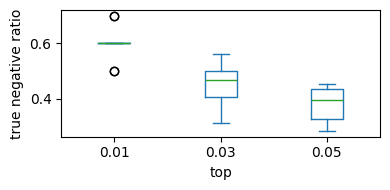

None

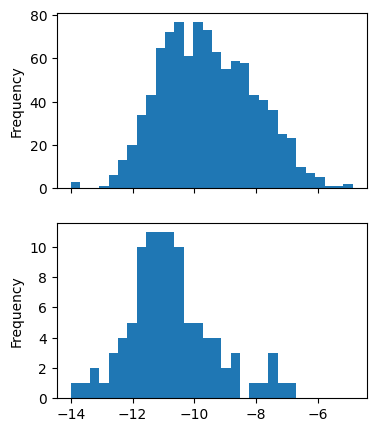

None

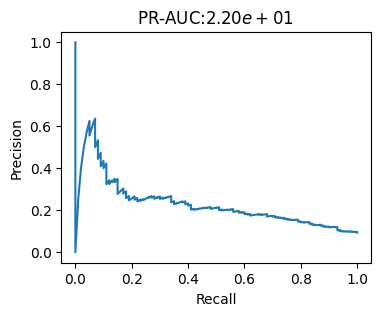

None

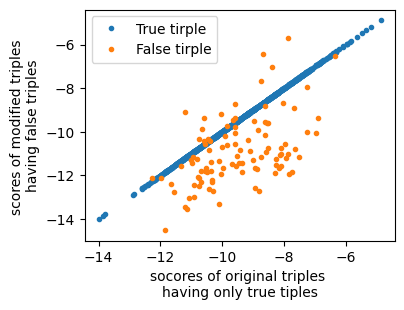

None

In [16]:
%matplotlib inline
display(HTML(f'<h2>Data Set: {dataset_name}</h2>'))
# Hits@k
display(HTML('<h3>Hits@K</h3>'))
display(HTML('<h4>Vanilla</h4>'))
display(sr_vhits_at_k.to_frame().T)
display(HTML('<h4>Filtered</h4>'))
display(sr_hits_at_k.to_frame().T)

# True negative ratio
display(HTML('<h3>True negative ratio</h3>'))

dict_data_tnr = {}
for i in dict_false_triples.keys():
    dict_data_tnr[i] = {}
    for k in dict_false_triples[i]['true_negative_ratio'].keys():
        dict_data_tnr[i][k] = dict_false_triples[i]['true_negative_ratio'][k]['value']
df_tnr = pd.DataFrame(dict_data_tnr).T
df_tnr.columns.name = 'Top'

sr_tnr_mean = df_tnr.mean()
sr_tnr_mean.name = 'tnr(mean)'
display(sr_tnr_mean.to_frame().T)

display(HTML('<h3>Boxplot of True Negative Ratio</h3>'))

fig_tnr, ax = plt.subplots(figsize=(4,2))
df_tnr.plot(kind='box', ax=ax)
ax.set_xlabel('top')
ax.set_ylabel('true negative ratio')
fig_tnr.tight_layout()
display(plt.show())

display(HTML('<h3>Example of Score Distribution</h3>'))
# Score distribution
first_key = list(dict_false_triples.keys())[0]
df_feature = dict_false_triples[first_key]['df_feature']
df_plot = df_feature
fig_score, axs = plt.subplots(figsize=(4,5), nrows=2, sharex=True)
sr_score_true = df_plot[df_plot['is-error']==False]['score']
sr_score_false = df_plot[df_plot['is-error']==True]['score']
vmin = min(sr_score_true.min(),sr_score_false.min())
vmax = max(sr_score_true.max(),sr_score_false.max())
sr_score_true.plot(kind='hist', ax=axs[0], range=(vmin, vmax), bins=30)
sr_score_false.plot(kind='hist', ax=axs[1], range=(vmin, vmax), bins=30)
display(plt.show())

display(HTML('<h3>Example of Precision-Recall Curve</h3>'))
plt.figure(figsize=(4,3))
precision, recall, thresholds = precision_recall_curve(df_plot['is-error'], -df_plot['score'], pos_label=True)
pr_auc = auc(recall, precision)
pr_auc = int(100*pr_auc)
plt.plot(recall, precision, '-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR-AUC:${pr_auc:.2e}$ ')
fig_score.tight_layout()
display(plt.show())

display(HTML('<h3>Comparison between scores of true and false tiples</h3>'))
fig_score_true_vs_false, ax = plt.subplots(figsize=(4,3))
df_sorted_feature[df_sorted_feature['is-error']==False].plot(x='score(org)', y='score', marker='.', lw=0, ax=ax, label='True tirple')
df_sorted_feature[df_sorted_feature['is-error']==True].plot(x='score(org)', y='score', marker='.', lw=0, ax=ax, label='False tirple')
ax.set_xlabel('socores of original triples \nhaving only true tiples')
ax.set_ylabel('scores of modified triples \nhaving false triples')
display(plt.show())

In [17]:
db = DataBinder(target_dir=dir_report)

INFO:root:Loaded info from ./reports/20240725/kinships_transe_false_triple_analysis/info.json


In [18]:
db.add('sr_hits_at_k', sr_hits_at_k)
db.add('sr_vhits_at_k', sr_vhits_at_k)
db.add('median_rank', mr)
db.add('df_tnr', df_tnr)
db.add('sr_tnr_mean', sr_tnr_mean)
db.add('fig_tnr', fig_tnr)
db.add('fig_score', fig_score)

INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
INFO:root:Saved info at 2024-07-25 11:59:39
